# Word Clouds
Lets look at word frequency use for different recent prime ministers.

In [1]:
import pandas as pd
import os
import sys
import json
import re
import random
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from collections import Counter, defaultdict

from wordcloud import WordCloud

stop_words = set(stopwords.words('english')) 
stop_words = stop_words.union(set(['ladies', 'gentlemen']))

In [2]:
# Add repo
git_dir = os.path.abspath('../')
sys.path.append(os.path.join(git_dir, 'lib', 'utils') )

# Define data output path
transcript_path = os.path.join(git_dir, 'data', 'pm-transcripts-processed/aggregated-spellfixed-typed.csv')

fig_dir = os.path.join(git_dir, 'figs')

#Read in, make string lists into strings
df_raw = pd.read_csv(transcript_path)
df_raw['sentences'] = df_raw['sentences'].map(eval)

In [3]:
pms = ['Abbott, Tony', 'Turnbull, Malcolm','Howard, John', 'Gillard, Julia','Rudd, Kevin']
# All other types dont have enough structure.
release_types = ['Media Releases', 'Speech']

df = df_raw[df_raw['pm'].isin(pms) & df_raw['type'].isin(release_types)]\
    .drop('Unnamed: 0', axis=1)

In [4]:
# Baseline language data
flat_corpus = ' '.join(df.sentences.sum())
token_corpus = word_tokenize(flat_corpus)
token_corpus_filtered = [w for w in token_corpus if not w in stop_words]
corpus_freqs = Counter(token_corpus_filtered)
most_common = corpus_freqs.most_common(300)
corpus_norm = len(token_corpus_filtered)

What you find if you compare the language of each PM naievely is that they all pretty much talk about the same things. It is dominated by baseline politispeach. You get a feel for the words used in the following word cloud. What we will do is account for the relative frequency that each leader uses a word, this should emphasise the difference in rhetoric used by each leader.

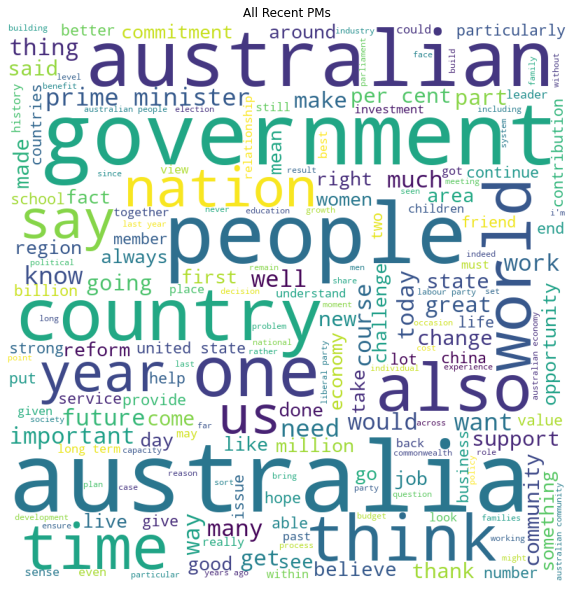

In [5]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(flat_corpus)

plt.figure(figsize = (8, 8), facecolor = None)
plt.title('All Recent PMs')
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
title = 'All'
plt.savefig(f'{fig_dir}/{title}.png')
plt.show()

In [6]:
likelyhoods = defaultdict(list) 
for pm_id in pms:
    pm_corpus = ' '.join(df[df['pm'] == pm_id].sentences.sum())
    pm_token_corpus_filtered =[w for w in word_tokenize(pm_corpus) if not w in stop_words]
    pm_freqs = Counter(pm_token_corpus_filtered)
    norm = len(pm_token_corpus_filtered)
    for word, count in most_common:
        # Get relative frequency 
        # Normalise for how much each speaker contributed to the corpus (class imbalance)
        likelyhoods[word].append(pm_freqs.get(word, 0)/norm/count*corpus_norm)

In [7]:
pm_wc_freq = [{}, {}, {}, {}, {}]
for i in range(5):
    for word in likelyhoods:
        pm_wc_freq[i][word] = int(likelyhoods[word][i]*1000)

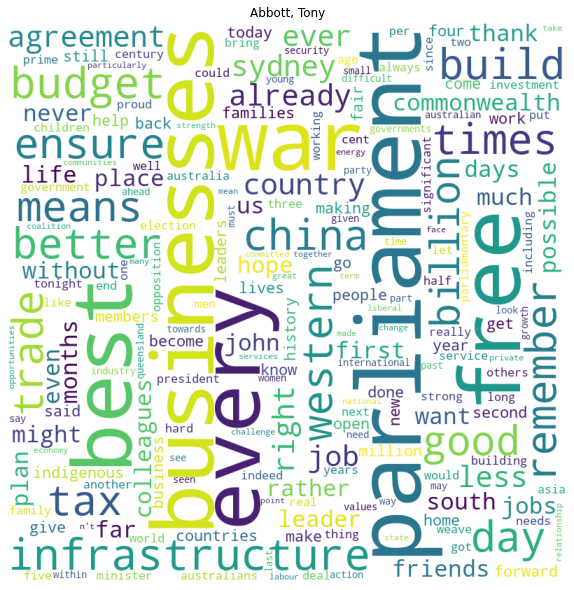

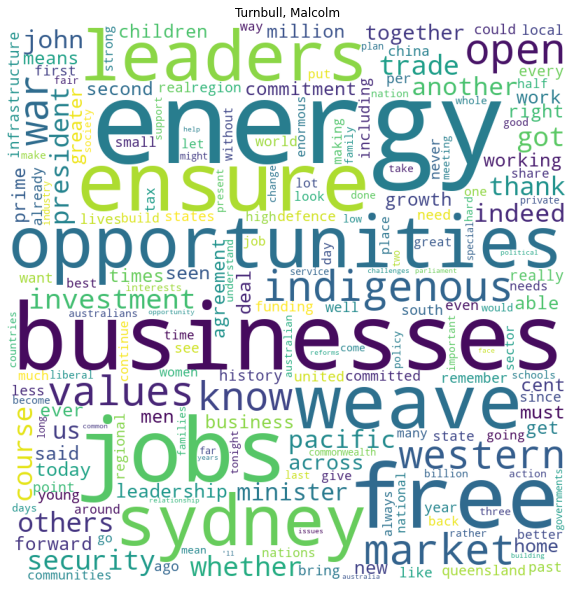

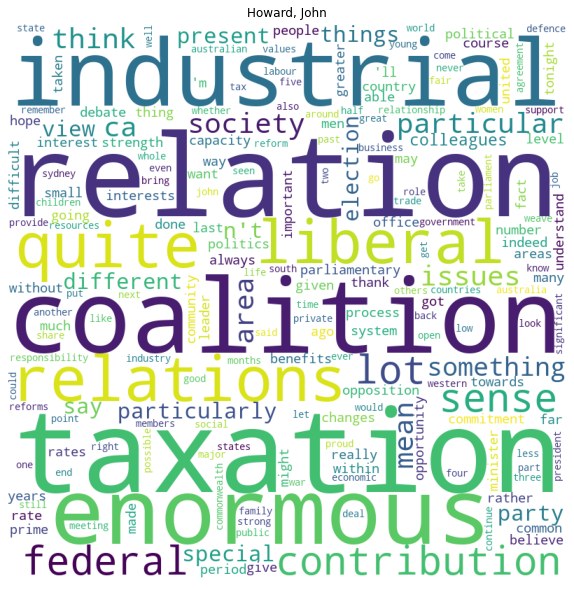

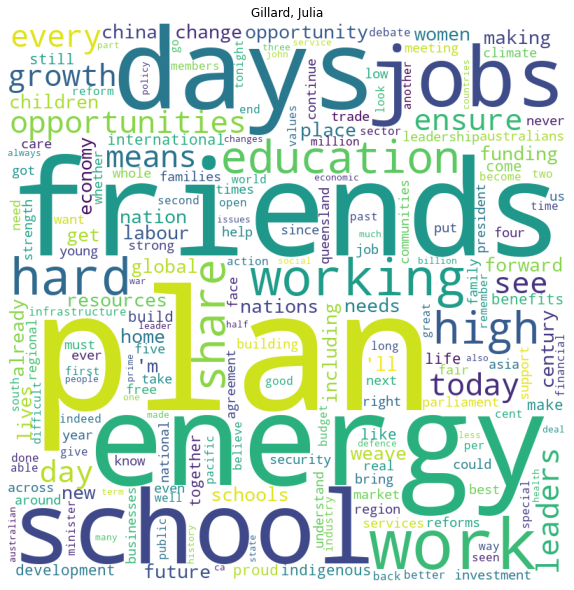

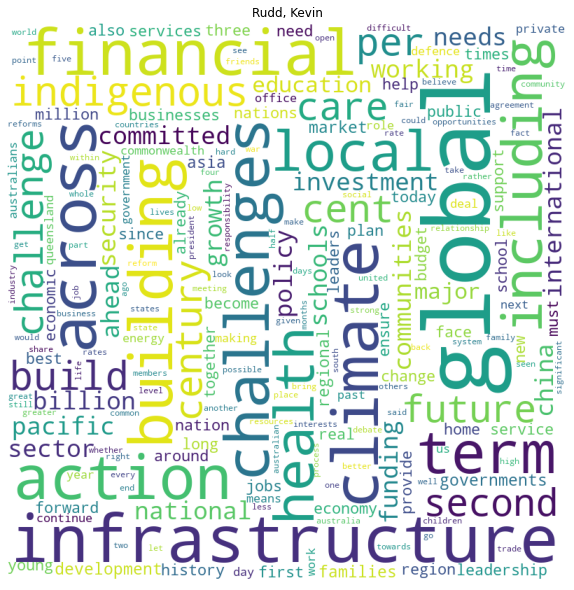

In [8]:
random.seed(1)
for i in range(5):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stop_words, 
                    min_font_size = 10)
    wordcloud.generate_from_frequencies(frequencies=pm_wc_freq[i])

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(pms[i])
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    title = pms[i].split(',')[0]
    plt.savefig(f'{fig_dir}/{title}.png')
    plt.show()